In this notebook we will explore our intiail dataset. The dataset contains data about coral coverage in two different main locations over multiple decades.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

In [2]:
df = pd.read_csv("coral_dataset.csv") #read in the dataset

In [3]:
df #print and look at the data set 

,Date,site,transect,quadrat,percentCover_allCoral,percentCover_macroalgae,percentCover_CTB
0,1987/12/01,Tektite,1,T1Q1,16.5,3.5,6
1,1987/12/01,Tektite,1,T1Q2,10,6,74
2,1987/12/01,Tektite,1,T1Q3,13.5,3.5,45
3,1987/12/01,Tektite,1,T1Q4,15.5,6.5,61.5
4,1987/12/01,Tektite,1,T1Q5,19,4,48
...,...,...,...,...,...,...,...
2278,2021/07/01,Yawzi,nd,6,0.0,30.0,50.0
2279,2021/07/01,Yawzi,nd,7,0.0,28.5,45.5
2280,2021/07/01,Yawzi,nd,8,0.5,35.0,35.0
2281,2021/07/01,Yawzi,nd,9,0.5,42.0,42.5


In [6]:
df = df[df['percentCover_CTB'] != 'nd'] #drop all of the rows with these entries and then print out the amount of rows in our dataset
df = df[df['percentCover_macroalgae'] != 'nd']
df = df[df['percentCover_allCoral'] != 'nd']
print(len(df))

2264


In [7]:
columns_to_cast = ['percentCover_CTB', 'percentCover_macroalgae', 'percentCover_allCoral'] #get a list of the columns that we want to cast
df[columns_to_cast] = df[columns_to_cast].astype(float) #cast these columns as floats and divide by 100 to make the percents 
df[columns_to_cast] = df[columns_to_cast]/100
df['percentCover_other'] = 1 - (df['percentCover_CTB']+df['percentCover_macroalgae']) #add in another column for other types of coral

In [9]:
# convert the date column to date time objects
df.index = pd.to_datetime(df.index)

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv, norm

In [26]:
df = pd.read_csv("coral_dataset.csv", index_col = "Date") #read in the dataset 
df = df[df['percentCover_CTB'] != 'nd'] #drop all of the rows with these entries and then print out the amount of rows in our dataset
df = df[df['percentCover_macroalgae'] != 'nd']
df = df[df['percentCover_allCoral'] != 'nd']
columns_to_cast = ['percentCover_CTB', 'percentCover_macroalgae', 'percentCover_allCoral'] #get a list of the columns that we want to cast
df[columns_to_cast] = df[columns_to_cast].astype(float) #cast these columns as floats and divide by 100 to make the percents 
df[columns_to_cast] = df[columns_to_cast]/100
df['percentCover_other'] = 1 - (df['percentCover_CTB']+df['percentCover_macroalgae']) #add in another column for other types of coral
df.index = pd.to_datetime(df.index)
df['year_column'] = df.index.year

df_tektite = df[df['site']=='Tektite']
avg_percent_cover_allcoral_tektite = df_tektite.groupby('year_column')['percentCover_allCoral'].mean()

tek = np.diff(avg_percent_cover_allcoral_tektite)

In [27]:
df = pd.read_csv("coral_dataset.csv", index_col = "Date") #read in the dataset 
df = df[df['percentCover_CTB'] != 'nd'] #drop all of the rows with these entries and then print out the amount of rows in our dataset
df = df[df['percentCover_macroalgae'] != 'nd']
df = df[df['percentCover_allCoral'] != 'nd']
columns_to_cast = ['percentCover_CTB', 'percentCover_macroalgae', 'percentCover_allCoral'] #get a list of the columns that we want to cast
df[columns_to_cast] = df[columns_to_cast].astype(float) #cast these columns as floats and divide by 100 to make the percents 
df[columns_to_cast] = df[columns_to_cast]/100
df['percentCover_other'] = 1 - (df['percentCover_CTB']+df['percentCover_macroalgae']) #add in another column for other types of coral
df.index = pd.to_datetime(df.index)
df['year_column'] = df.index.year

df_tektite = df[df['site']=='Yawzi']
avg_percent_cover_allcoral_yawzi = df_tektite.groupby('year_column')['percentCover_allCoral'].mean()

yaw = np.diff(avg_percent_cover_allcoral_tektite)

In [66]:

class KalmanFilter(object):
    def __init__(self,F,Q,H,R,u):
        """
        Initialize the dynamical system models.
        
        Parameters
        ----------
        F : ndarray of shape (n,n)
            The state transition model.
        Q : ndarray of shape (n,n)
            The covariance matrix for the state noise.
        H : ndarray of shape (m,n)
            The observation model.
        R : ndarray of shape (m,m)
            The covariance matrix for observation noise.
        u : ndarray of shape (n,)
            The control vector.
        """
        #save attributes
        self.F=F
        self.Q=Q
        self.H=H
        self.R=R
        self.u=u
    
    def evolve(self,x0,N):
        """
        Compute the first N states and observations generated by the Kalman system.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state.
        N : integer
            The number of time steps to evolve.

        Returns
        -------
        states : ndarray of shape (n,N)
            The i-th column gives the i-th state.
        obs : ndarray of shape (m,N)
            The i-th column gives the i-th observation.
        """
        #initialize states matrix
        n=len(x0)
        m=len(self.H@x0)
        states=np.zeros((n,N))
        states[:,0]=x0
        obs=np.zeros((m,N))
        obs[:,0]=self.H@(states[:,0])
        for i in range(1,N):
            #get noise
            w=np.random.multivariate_normal(np.zeros_like(states[:,0]), self.Q)
            v=np.random.multivariate_normal(np.zeros_like(obs[:,0]), self.R)
            #update states
            states[:,i]=self.F@states[:,i-1]+self.u+w
            #update obs
            obs[:,i]=self.H@states[:,i]+v
        return states, obs

    def estimate(self,x0,P0,z, return_norms = False):
        """
        Compute the state estimates using the kalman filter.

        Parameters
        ----------
        x0 : ndarray of shape (n,)
            The initial state estimate.
        P0 : ndarray of shape (n,n)
            The initial error covariance matrix.
        z : ndarray of shape(m,N)
            Sequence of N observations (each column is an observation).

        Returns
        -------
        out : ndarray of shape (n,N)
            Sequence of state estimates (each column is an estimate).
        """
        #initialize states matrix
        n=len(x0)
        m,N=z.shape
        states=np.zeros((n,N))
        P=P0
        states[:,0]=x0
        #iterate to get states
        for i in range(1,N):
            #predict phase
            xkk1=self.F@states[:,i-1]+self.u
            Pkk1=self.F@P@self.F.T+self.Q
            #update step
            y=z[:,i]-self.H@xkk1
            S=self.H@Pkk1@self.H.T+self.R
            K=Pkk1@self.H.T@inv(S)
            states[:,i]=xkk1+K@y
            P=(np.eye(n)-K@self.H)@P
        return states
            
    
    def predict(self,x,k):
        """
        Predict the next k states in the absence of observations.

        Parameters
        ----------
        x : ndarray of shape (n,)
            The current state estimate.
        k : integer
            The number of states to predict.

        Returns
        -------
        out : ndarray of shape (n,k)
            The next k predicted states.
        """
        #initialize states matrix
        n=len(x)
        states=np.zeros((n,k))
        states[:,0]=self.F@x+self.u
        #iterate to get k next steps
        for i in range(1,k):
            states[:,i]=self.F@states[:,i-1]+self.u
        return states
    
    def rewind(self,x,k):
        """
        Predict the states from time 0 through k-1 in the absence of observations.
    
        Parameters
        ----------
        x : ndarray of shape (n,)
            The state estimate at time k.
        k : integer
            The current time step.
    
        Returns
        -------
        out : ndarray of shape (n,k)
            The predicted states from time 0 up through k-1 (in that order).
        """
        #get F^-1
        Finv=inv(self.F)
        n=len(x)
        states=np.zeros((n,k))
        #get most previous step
        states[:,-1]=Finv@(x-self.u)
        #iterate to get k steps
        for i in range(k-2,-1,-1):
            states[:,i]=Finv@(states[:,i+1]-self.u)
        return states


In [ ]:
F=np.linspace(.05,2.5,20)
Q=np.linspace(0.001,0.02,4)
H=np.linspace(0.001,3,20)
R=np.linspace(0.0001,.5,4)
best_mse=np.inf
for f in F:
    for q in Q:
        for h in H:
            for r in R:
                kf=KalmanFilter(np.array([[f]]),np.array([[q]]),np.array([[h]]),np.array([[r]]),u=np.zeros(1))
                states, obs= kf.evolve([avg_percent_cover_allcoral_yawzi.iloc[0]], 30)
                mse = np.mean((obs - np.array(avg_percent_cover_allcoral_yawzi)[-5])**2)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (f,q,h,r)
                    beststates=states
                    bestobs=obs

In [96]:
f,q,h,r = (0.9526315789473685, 0.001, 0.1588421052631579, 0.0001)
kf=KalmanFilter(np.array([[f]]),np.array([[q]]),np.array([[h]]),np.array([[r]]),u=np.zeros(1))
states, bestobs = kf.evolve([avg_percent_cover_allcoral_yawzi.iloc[0]], 40)

0.010863811043616518
(0.9526315789473685, 0.001, 1.263736842105263, 0.0001)


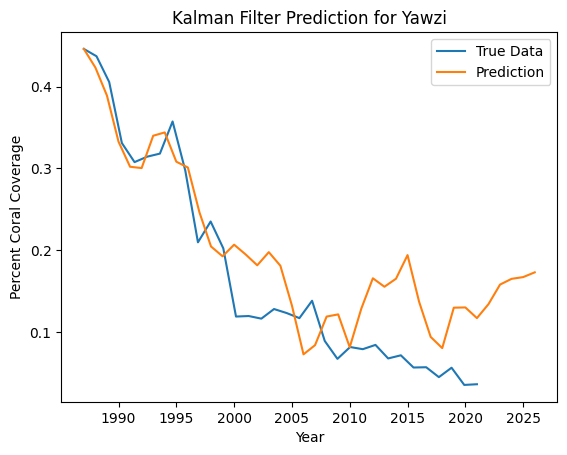

In [97]:
print(best_mse)
print(best_params)
x = np.linspace(1987,2021,len(avg_percent_cover_allcoral_yawzi))
x1 = np.linspace(1987,2026,len(states[0]))
plt.plot(x,avg_percent_cover_allcoral_yawzi, label = 'True Data')
plt.plot(x1, states[0], label = 'Prediction')
plt.title('Kalman Filter Prediction for Yawzi')
plt.ylabel('Percent Coral Coverage')
plt.xlabel('Year')
plt.legend()
plt.show()


In [82]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [98]:
print(f"MSE for Yawzi Test {mean_squared_error(avg_percent_cover_allcoral_yawzi[-5:],states[0][30:-5])}")
print(f"RMSE for Yawzi Test {np.sqrt(mean_squared_error(avg_percent_cover_allcoral_yawzi[-5:],states[0][30:-5]))}")
print(f"MAE for Yawzi Test {mean_absolute_error(avg_percent_cover_allcoral_yawzi[-5:],states[0][30:-5])}")
print(f"R2 for Yawzi Test {r2_score(avg_percent_cover_allcoral_yawzi[-5:],states[0][30:-5])}")


MSE for Yawzi Test 0.004714895231061715
RMSE for Yawzi Test 0.06866509470656627
MAE for Yawzi Test 0.06436685871918293
R2 for Yawzi Test -52.6212451241687


In [120]:
F=np.linspace(.05,1.5,20)
Q=np.linspace(0.001,0.03,4)
H=np.linspace(0.001,2,20)
R=np.linspace(0.0001,.5,4)
best_mse=np.inf
for f in F:
    for q in Q:
        for h in H:
            for r in R:
                kf=KalmanFilter(np.array([[f]]),np.array([[q]]),np.array([[h]]),np.array([[r]]),u=np.zeros(1))
                states, obs= kf.evolve([avg_percent_cover_allcoral_tektite.iloc[0]], 30)
                mse = np.mean((obs - np.array(avg_percent_cover_allcoral_tektite)[-5])**2)
                if mse < best_mse:
                    best_mse = mse
                    best_params = (f,q,h,r)
                    beststates=states
                    bestobs=obs

In [143]:
f,q,h,r = best_params
kf=KalmanFilter(np.array([[f]]),np.array([[q]]),np.array([[h]]),np.array([[r]]),u=np.zeros(1))
states, bestobs = kf.evolve([avg_percent_cover_allcoral_tektite.iloc[0]], 40)

0.0039343621682250895
(0.9657894736842105, 0.001, 0.9478947368421052, 0.0001)


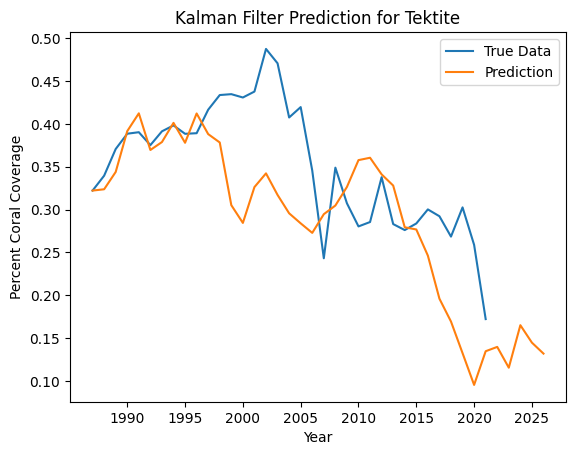

In [144]:
print(best_mse)
print(best_params)
x = np.linspace(1987,2021,len(avg_percent_cover_allcoral_tektite))
x1 = np.linspace(1987,2026,len(bestobs[0]))
plt.plot(x,avg_percent_cover_allcoral_tektite,label = 'True Data')
plt.plot(x1, states[0], label = 'Prediction')
plt.title('Kalman Filter Prediction for Tektite')
plt.ylabel('Percent Coral Coverage')
plt.xlabel('Year')
plt.legend()
plt.show()

In [146]:
print(f"MSE for Tektite Test {mean_squared_error(avg_percent_cover_allcoral_tektite[-5:],states[0][30:-5])}")
print(f"RMSE for Tektite Test {np.sqrt(mean_squared_error(avg_percent_cover_allcoral_tektite[-5:],states[0][30:-5]))}")
print(f"MAE for Tektite Test {mean_absolute_error(avg_percent_cover_allcoral_tektite[-5:],states[0][30:-5])}")
print(f"R2 for Tektite Test {r2_score(avg_percent_cover_allcoral_tektite[-5:],states[0][30:-5])}")


MSE for Tektite Test 0.015251066164043328
RMSE for Tektite Test 0.12349520704887024
MAE for Tektite Test 0.1133635766891387
R2 for Tektite Test -6.165586205377412
